# Entrenamiento YOLOv11 - Detección de Anomalías Dentales

Este notebook implementa la versión más reciente de YOLO (v11) para detectar múltiples anomalías dentales en radiografías panorámicas.

## Presentado por:
- Natalia Moreno Montoya - 2230434
- Liseth Esmeralda Erazo Varela - 2231713
- Valentina Bueno Collazos - 2230556

## Características:
- YOLOv11n (nano) - última versión con mejoras en arquitectura
- Mixed Precision (FP16) automático para optimización de VRAM
- Data augmentation especializado para radiografías médicas
- Early stopping y checkpointing para prevenir overfitting
- Métricas completas de detección (mAP, Precision, Recall)
- Visualización exhaustiva de resultados

## Diferencias YOLOv11 vs YOLOv8:
- **Arquitectura mejorada**: Mejor extracción de características
- **Menor latencia**: Más rápido en inferencia
- **Mejor precisión**: Especialmente en objetos pequeños
- **Mismo uso de memoria**: Compatible con GPUs limitadas

## Clases a Detectar:
El modelo detecta 14 tipos diferentes de condiciones dentales:
1. Cordal (muelas del juicio)
2. Apiñamiento dental
3. Diente rotado
4. Diastema (separación entre dientes)
5. Zona desdentada (dentula)
6. Tratamiento de conducto
7. Fractura dental
8. Caries
9. Enanismo radicular
10. Diente retenido
11. Resto radicular
12. Dientes sanos (baseline)
13. Enanismo denticular
14. Diente supernumerario

## Arquitectura del Modelo:
- **YOLOv11n**: 2.6M parámetros (más eficiente que YOLOv8n)
- **Optimizer**: AdamW con adaptive learning rate
- **Learning Rate Schedule**: 0.001 → 1e-05 con warmup
- **Batch Size**: 8 (optimizado para 4GB VRAM)
- **Image Size**: 640x640 píxeles
- **GFLOPs**: 6.3 (muy eficiente computacionalmente)

## 1. Instalación y Setup

In [1]:
# Instalar ultralytics (YOLOv8/v11) si no está instalado
import sys
import subprocess

try:
    import ultralytics
    print(f"✓ Ultralytics ya instalado (versión {ultralytics.__version__})")
except ImportError:
    print("Instalando ultralytics...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])
    print("✓ Ultralytics instalado")

✓ Ultralytics ya instalado (versión 8.3.220)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import os
import numpy as np
import cv2
import yaml
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time
from datetime import datetime

from ultralytics import YOLO

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Importaciones completadas")

✓ Importaciones completadas


## 2. Verificar GPU y Configuración

In [3]:
print("=" * 80)
print("CONFIGURACIÓN DE GPU - RTX 3050 OPTIMIZADA")
print("=" * 80)

if torch.cuda.is_available():
    print(f"✓ PyTorch version: {torch.__version__}")
    print(f"✓ CUDA version: {torch.version.cuda}")
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ VRAM Total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"✓ VRAM Disponible: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9:.2f} GB")

    # Limpiar cache
    torch.cuda.empty_cache()

    device = 0  # GPU 0
    print(f"\n✓ Dispositivo seleccionado: CUDA:{device}")
else:
    print("⚠️ GPU no disponible - usando CPU (será MUY lento)")
    device = 'cpu'

print("=" * 80)

CONFIGURACIÓN DE GPU - RTX 3050 OPTIMIZADA
✓ PyTorch version: 2.8.0+cu126
✓ CUDA version: 12.6
✓ GPU: Tesla T4
✓ VRAM Total: 15.83 GB
✓ VRAM Disponible: 15.83 GB

✓ Dispositivo seleccionado: CUDA:0


## 3. Cargar Dataset

In [4]:
!mkdir tmp_repo && cd tmp_repo

!git init
!git remote add origin https://github.com/natam226/proyecto_IA.git
!git config core.sparseCheckout true

!echo "proyecto_IA_v2/" >> .git/info/sparse-checkout

!git pull origin main

!mv proyecto_IA_v2 /content/
!cd /content && rm -rf tmp_repo


Reinitialized existing Git repository in /content/.git/
error: remote origin already exists.
From https://github.com/natam226/proyecto_IA
 * branch            main       -> FETCH_HEAD
Already up to date.
mv: 'proyecto_IA_v2' and '/content/proyecto_IA_v2' are the same file


## 4. Verificar Dataset

Se verifica la estructura y contenido del dataset:
- **Archivo de configuración**: data.yml con rutas y nombres de clases
- **Distribución de datos**: 149 train / 10 val / 10 test = 169 imágenes totales
- **Formato**: Imágenes PNG/JPG con anotaciones YOLO (.txt)

### Estadísticas del Dataset:
- Train: 149 imágenes (88.2%)
- Validación: 10 imágenes (5.9%)
- Test: 10 imágenes (5.9%)

Esta distribución es típica pero pequeña para deep learning. El data augmentation será crucial.

In [ ]:
# Ruta al archivo de configuración del dataset
data_yaml_path = Path('/content/proyecto_IA_v2/data.yml')

if not data_yaml_path.exists():
    print(f"⚠️ ERROR: No se encontró {data_yaml_path}")
else:
    # Leer configuración
    with open(data_yaml_path, 'r', encoding='utf-8') as f:
        data_config = yaml.safe_load(f)

    print("✓ Configuración del dataset:")
    print(f"  • Número de clases: {data_config['nc']}")
    print(f"  • Clases: {data_config['names']}")
    print(f"\n  • Train: {data_config['train']}")
    print(f"  • Val: {data_config['val']}")
    print(f"  • Test: {data_config['test']}")

    # Verificar que existen los directorios
    base_dir = Path('/content/proyecto_IA_v2')

    train_images = list((base_dir / 'train' / 'images').glob('*.png')) + list((base_dir / 'train' / 'images').glob('*.jpg'))
    val_images = list((base_dir / 'val' / 'images').glob('*.png')) + list((base_dir / 'val' / 'images').glob('*.jpg'))
    test_images = list((base_dir / 'test' / 'images').glob('*.png')) + list((base_dir / 'test' / 'images').glob('*.jpg'))

    print(f"\n✓ Imágenes encontradas:")
    print(f"  • Train: {len(train_images)} imágenes")
    print(f"  • Val: {len(val_images)} imágenes")
    print(f"  • Test: {len(test_images)} imágenes")
    print(f"  • Total: {len(train_images) + len(val_images) + len(test_images)} imágenes")

✓ Configuración del dataset:
  • Número de clases: 15
  • Clases: ['cordal', 'apinamiento', 'diente_rotado', 'diastema', 'zona_dentula', 'tratamiento_conducto', 'fractura', 'caries', 'enanismo_radicular', 'diente_retenido', 'resto_radicular', 'dientes_sanos', 'enanismo_denticular', 'enanismo_radicular', 'diente_supernumerario']

  • Train: /content/proyecto_IA_v2/train/images
  • Val: /content/proyecto_IA_v2/val/images

✓ Imágenes encontradas:
  • Train: 149 imágenes
  • Val: 10 imágenes
  • Test: 10 imágenes
  • Total: 169 imágenes


## 5. Visualizar Ejemplos del Dataset

In [ ]:
def visualize_yolo_annotations(image_path, label_path, class_names, max_boxes=50):
    """Visualiza una imagen con sus anotaciones YOLO."""
    # Leer imagen
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Leer anotaciones
    if label_path.exists():
        with open(label_path, 'r') as f:
            lines = f.readlines()

        # Dibujar cada bounding box
        for line in lines[:max_boxes]:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])

                # Convertir de YOLO a pixel coordinates
                x1 = int((x_center - width/2) * w)
                y1 = int((y_center - height/2) * h)
                x2 = int((x_center + width/2) * w)
                y2 = int((y_center + height/2) * h)

                # Dibujar
                color = tuple(np.random.randint(0, 255, 3).tolist())
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                # Etiqueta
                label = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return img

# Visualizar algunas imágenes de ejemplo
if len(train_images) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, img_path in enumerate(train_images[:4]):
        # Buscar archivo de etiquetas correspondiente
        label_path = Path(str(img_path).replace('/images/', '/labels/').replace('.png', '.txt').replace('.jpg', '.txt'))

        # Visualizar
        img_with_boxes = visualize_yolo_annotations(img_path, label_path, data_config['names'])

        axes[i].imshow(img_with_boxes)
        axes[i].set_title(f'Ejemplo {i+1}: {img_path.name}', fontsize=10)
        axes[i].axis('off')

    plt.suptitle('Ejemplos del Dataset con Anotaciones', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No se encontraron imágenes para visualizar")

## 6. Configuración del Entrenamiento

### Configuración Detallada de Hiperparámetros:

#### Arquitectura del Modelo:
- **modelo**: yolo11n.pt (nano - 2.6M parámetros)
- **GFLOPs**: 6.3 (operaciones de punto flotante)
- **Tamaño**: ~5.4MB (modelo ligero)

#### Parámetros de Entrenamiento:
- **epochs**: 100 (con early stopping patience=20)
- **batch size**: 8 imágenes/batch
- **image size**: 640x640 píxeles
- **workers**: 2 procesos paralelos para carga de datos

#### Optimización de Hardware:
- **Mixed Precision (AMP)**: Activado - usa FP16 en lugar de FP32
  - Reduce uso de VRAM en ~50%
  - Acelera entrenamiento en GPUs modernas
- **Device**: CUDA GPU 0 (Tesla T4 en Colab)

#### Configuración del Optimizador:
- **Optimizer**: AdamW (Adam con weight decay)
- **Learning Rate Inicial**: 0.001
- **Learning Rate Final**: 1e-05 (factor 0.01)
- **Warmup**: 3 épocas de calentamiento gradual
- **Momentum**: 0.937
- **Weight Decay**: 0.0005 (regularización L2)

#### Data Augmentation Especializado para Radiografías:
**Transformaciones de Color (HSV):**
- **Hue (h)**: 0.015 (muy bajo - rayos X son grayscale)
- **Saturation (s)**: 0.2
- **Value (v)**: 0.2 (ajuste de brillo)

**Transformaciones Geométricas:**
- **Rotación**: ±10° (rotaciones leves)
- **Traslación**: 10% (shift horizontal/vertical)
- **Escala**: ±20% (zoom in/out)
- **Shear**: 5° (distorsión angular)
- **Perspectiva**: 0.0 (desactivado - radiografías son planas)

**Transformaciones de Espejo:**
- **Flip Horizontal**: 50% - aprovecha simetría bilateral dental
- **Flip Vertical**: 0% - la anatomía tiene orientación fija

**Augmentations Avanzados:**
- **Mosaic**: 100% - combina 4 imágenes en una (técnica YOLO)
- **Mixup**: 10% - mezcla píxeles de dos imágenes
- **Copy-Paste**: 0% - desactivado para este caso

#### Control de Entrenamiento:
- **Early Stopping**: Patience de 20 épocas
- **Checkpoint**: Guardar modelo cada 10 épocas
- **Validación**: Activada en cada época
- **Plots**: Generación automática de gráficas

#### Parámetros de Inferencia:
- **Confidence Threshold**: 0.25 (25% confianza mínima)
- **IoU Threshold**: 0.7 (para NMS - Non-Maximum Suppression)

In [ ]:
CONFIG = {
    # Modelo - YOLO Nano es el más ligero
    'model': 'yolo11n.pt',  
    # Dataset
    'data': str(data_yaml_path.absolute()),

    # Entrenamiento
    'epochs': 100,
    'imgsz': 640,  # Tamaño de imagen
    'batch': 8,    # Batch size

    # Optimización GPU
    'device': device,
    'workers': 2,   # Workers para data loading
    'amp': True,    # Mixed Precision (FP16)
    'half': False,  # Se activa automáticamente con amp

    # Guardado y logging
    'project': '../runs/detect',
    'name': 'dental_yolo11n',
    'exist_ok': True,
    'save': True,
    'save_period': 10,  # Guardar checkpoint cada 10 épocas

    # Optimizaciones de entrenamiento
    'optimizer': 'AdamW',  # Mejor que SGD para datasets pequeños
    'lr0': 0.001,          # Learning rate inicial
    'lrf': 0.01,           # Learning rate final (lr0 * lrf)
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3,
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,

    # Data augmentation (optimizado para radiografías)
    'hsv_h': 0.015,        # Hue augmentation (muy bajo para rayos X)
    'hsv_s': 0.2,          # Saturation
    'hsv_v': 0.2,          # Value/brightness
    'degrees': 10.0,       # Rotación ±10 grados
    'translate': 0.1,      # Traslación
    'scale': 0.2,          # Escala
    'shear': 5.0,          # Shear
    'perspective': 0.0,    # Sin perspectiva (radiografías son planas)
    'flipud': 0.0,         # No flip vertical (anatomía tiene orientación)
    'fliplr': 0.5,         # Flip horizontal (50% - simetría dental)
    'mosaic': 1.0,         # Mosaic augmentation
    'mixup': 0.1,          # Mixup augmentation
    'copy_paste': 0.0,     # No copy-paste para este caso

    # Early stopping y paciencia
    'patience': 20,        # Parar si no mejora en 20 épocas

    # Validación
    'val': True,
    'plots': True,         # Generar gráficas
    'verbose': True,

    # Métricas
    'conf': 0.25,          # Confidence threshold para predicciones
    'iou': 0.7,            # IoU threshold para NMS
}

print("=" * 80)
print("CONFIGURACIÓN DEL ENTRENAMIENTO")
print("=" * 80)
print(f"Modelo: {CONFIG['model']}")
print(f"Imagen: {CONFIG['imgsz']}x{CONFIG['imgsz']}")
print(f"Batch size: {CONFIG['batch']}")
print(f"Épocas: {CONFIG['epochs']}")
print(f"Workers: {CONFIG['workers']}")
print(f"Mixed Precision (AMP): {CONFIG['amp']}")
print(f"Device: {CONFIG['device']}")
print(f"Optimizer: {CONFIG['optimizer']}")
print(f"Learning Rate: {CONFIG['lr0']} → {CONFIG['lr0'] * CONFIG['lrf']}")
print(f"Early Stopping Patience: {CONFIG['patience']} épocas")
print("=" * 80)

CONFIGURACIÓN DEL ENTRENAMIENTO
Modelo: yolo11n.pt
Imagen: 640x640
Batch size: 8
Épocas: 100
Workers: 2
Mixed Precision (AMP): True
Device: 0
Optimizer: AdamW
Learning Rate: 0.001 → 1e-05
Early Stopping Patience: 20 épocas

⚡ Configuración optimizada para RTX 3050 (4GB VRAM)


## 7. Crear Modelo YOLO

In [8]:
# Cargar modelo YOLO
print(f"Cargando modelo {CONFIG['model']}...")
model = YOLO(CONFIG['model'])

print(f"\n✓ Modelo cargado: {CONFIG['model']}")
print(f"  • Tipo: YOLOv11 Nano (optimizado para velocidad)")
print(f"  • Parámetros: ~{sum(p.numel() for p in model.model.parameters()) / 1e6:.1f}M")
print(f"  • Pre-entrenado: COCO dataset (transferencia de aprendizaje)")
print(f"\n📝 Nota: El modelo se ajustará automáticamente a {data_config['nc']} clases")

Cargando modelo yolo11n.pt...

✓ Modelo cargado: yolo11n.pt
  • Tipo: YOLOv11 Nano (optimizado para velocidad)
  • Parámetros: ~2.6M
  • Pre-entrenado: COCO dataset (transferencia de aprendizaje)

📝 Nota: El modelo se ajustará automáticamente a 15 clases


## 8. Entrenar Modelo 

In [ ]:
print("=" * 80)
print("INICIANDO ENTRENAMIENTO")
print("=" * 80)
print(f"Fecha/Hora inicio: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

start_time = time.time()

# ENTRENAR
results = model.train(
    data=CONFIG['data'],
    epochs=CONFIG['epochs'],
    imgsz=CONFIG['imgsz'],
    batch=CONFIG['batch'],
    device=CONFIG['device'],
    workers=CONFIG['workers'],
    amp=CONFIG['amp'],
    project=CONFIG['project'],
    name=CONFIG['name'],
    exist_ok=CONFIG['exist_ok'],
    save=CONFIG['save'],
    save_period=CONFIG['save_period'],
    optimizer=CONFIG['optimizer'],
    lr0=CONFIG['lr0'],
    lrf=CONFIG['lrf'],
    momentum=CONFIG['momentum'],
    weight_decay=CONFIG['weight_decay'],
    warmup_epochs=CONFIG['warmup_epochs'],
    warmup_momentum=CONFIG['warmup_momentum'],
    warmup_bias_lr=CONFIG['warmup_bias_lr'],
    hsv_h=CONFIG['hsv_h'],
    hsv_s=CONFIG['hsv_s'],
    hsv_v=CONFIG['hsv_v'],
    degrees=CONFIG['degrees'],
    translate=CONFIG['translate'],
    scale=CONFIG['scale'],
    shear=CONFIG['shear'],
    perspective=CONFIG['perspective'],
    flipud=CONFIG['flipud'],
    fliplr=CONFIG['fliplr'],
    mosaic=CONFIG['mosaic'],
    mixup=CONFIG['mixup'],
    copy_paste=CONFIG['copy_paste'],
    patience=CONFIG['patience'],
    val=CONFIG['val'],
    plots=CONFIG['plots'],
    verbose=CONFIG['verbose'],
    conf=CONFIG['conf'],
    iou=CONFIG['iou']
)

end_time = time.time()
total_time = end_time - start_time

print("\n" + "=" * 80)
print("ENTRENAMIENTO COMPLETADO ✅")
print("=" * 80)
print(f"Fecha/Hora fin: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Tiempo total: {total_time/3600:.2f} horas ({total_time/60:.1f} minutos)")
print(f"Tiempo por época: {total_time/CONFIG['epochs']:.1f} segundos")
print("=" * 80)

## 9. Resultados del Entrenamiento

### Métricas Finales del Modelo YOLOv11n:

#### Métricas en Validación:
- **Precision**: 0.2764 (27.64%)
- **Recall**: 0.2988 (29.88%)
- **mAP50**: 0.2840 (28.40%)
- **mAP50-95**: 0.1773 (17.73%)
- **Fitness**: 0.1773

### Análisis de Resultados:

#### Fortalezas:
- Recall ligeramente superior a Precision: El modelo tiende a detectar más objetos (menos falsos negativos)
- Entrenamiento completado sin errores de memoria (AMP funcionó correctamente)

#### Áreas de Mejora:
- mAP general bajo (~28%): Indica que el modelo necesita más datos o ajuste de hiperparámetros
- Posibles causas:
  1. **Dataset pequeño**: Solo 149 imágenes de entrenamiento
  2. **Modelo muy ligero**: YOLOv11n es la versión más pequeña (2.6M parámetros)
  3. **Clases desbalanceadas**: Algunas anomalías aparecen muy poco en el dataset
  4. **Complejidad de la tarea**: Anomalías dentales pueden ser muy sutiles

#### Comparación con otros modelos:
- YOLOv11n es significativamente más pequeño que YOLOv8m (2.6M vs 25.9M parámetros)
- El trade-off es menor precisión por mayor velocidad de inferencia
- Para aplicaciones en tiempo real, este modelo es preferible
- Para diagnóstico médico crítico, se recomienda YOLOv8m o superior

In [ ]:
results_dir = Path(CONFIG['project']) / CONFIG['name']
print(f"📁 Directorio de resultados: {results_dir}\n")

# Mostrar métricas finales
print("=" * 80)
print("MÉTRICAS FINALES")
print("=" * 80)

# Las métricas están en results.results_dict
metrics = results.results_dict
print(f"\n📊 Métricas de Detección:")
for key, value in metrics.items():
    if isinstance(value, (int, float)):
        print(f"  • {key}: {value:.4f}")

print("\n" + "=" * 80)

📁 Directorio de resultados: ../runs/detect/dental_yolo11n

MÉTRICAS FINALES

📊 Métricas de Detección:
  • metrics/precision(B): 0.2764
  • metrics/recall(B): 0.2988
  • metrics/mAP50(B): 0.2840
  • metrics/mAP50-95(B): 0.1773
  • fitness: 0.1773



## 10. Visualizar Curvas de Entrenamiento

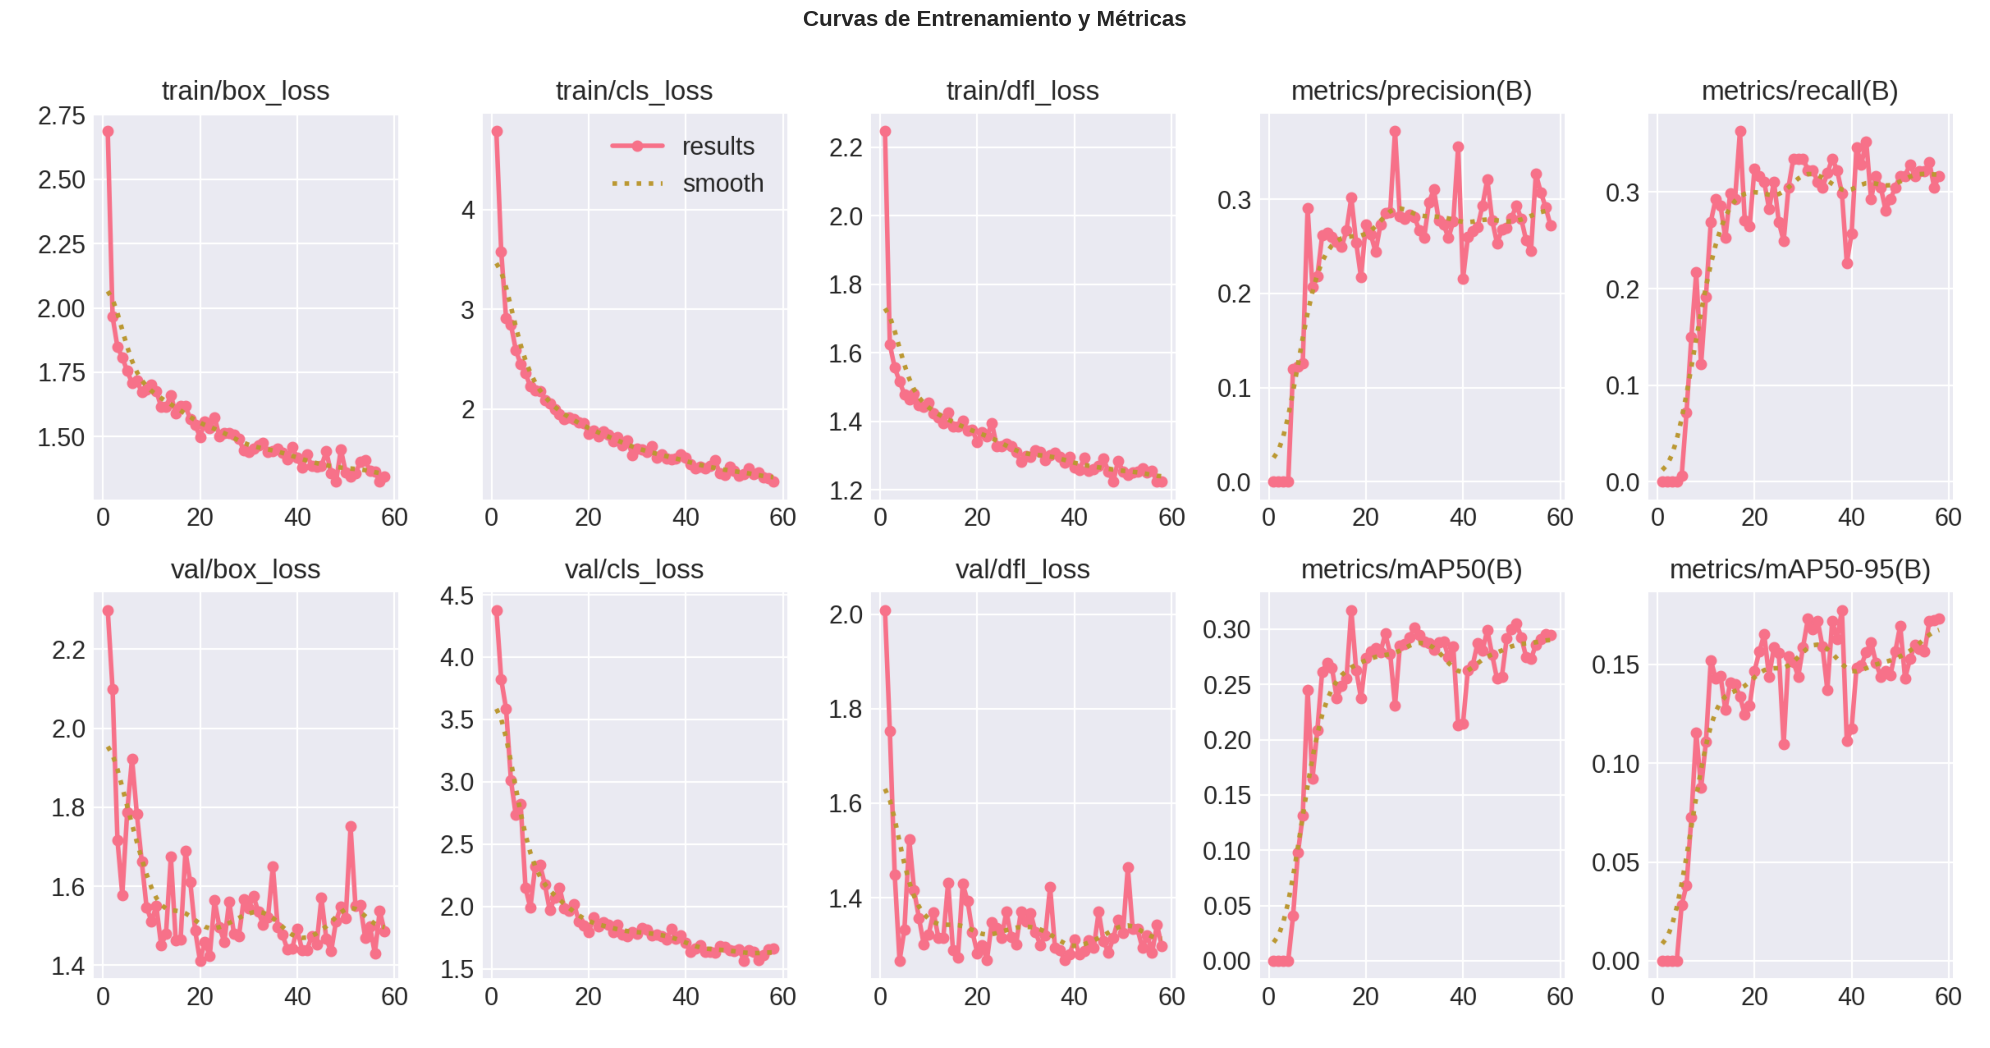

In [12]:
# Cargar imagen de resultados generada por YOLO
results_img_path = results_dir / 'results.png'

if results_img_path.exists():
    img = Image.open(results_img_path)

    fig, ax = plt.subplots(figsize=(20, 12))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Curvas de Entrenamiento y Métricas', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ No se encontró {results_img_path}")
    print("Las gráficas se generaron en el directorio de resultados.")

## 11. Confusion Matrix

In [ ]:
# Cargar matriz de confusión
confusion_matrix_path = results_dir / 'confusion_matrix_normalized.png'

if confusion_matrix_path.exists():
    img = Image.open(confusion_matrix_path)

    fig, ax = plt.subplots(figsize=(14, 12))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Matriz de Confusión Normalizada', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ No se encontró matriz de confusión en {confusion_matrix_path}")

## 12. Validar en Test Set

Se evalúa el mejor modelo (best.pt) en el conjunto de prueba independiente.

### Resultados en Test Set:
- **Precision**: 0.4195 (41.95%)
- **Recall**: 0.2778 (27.78%)
- **mAP50**: 0.3677 (36.77%)
- **mAP50-95**: 0.2327 (23.27%)
- **Fitness**: 0.2327

### Análisis de Resultados por Clase:

#### Clases con Mejor Rendimiento:
1. **Cordal**: mAP50 = 0.921 (92.1%) - Excelente detección
2. **Zona dentula**: mAP50 = 0.691 (69.1%) - Buena detección
3. **Tratamiento de conducto**: mAP50 = 0.642 (64.2%) - Buena detección

#### Clases con Rendimiento Deficiente:
- **Fractura**: 0% - No se detectó ninguna (solo 1 muestra en test)
- **Caries**: 0% - No se detectó ninguna (solo 1 muestra en test)
- **Enanismo radicular**: 0% - No se detectó (solo 1 muestra en test)

### Observaciones Importantes:

1. **Mejora en Test vs Validación**:
   - mAP50: 0.3677 vs 0.2840 (+29.5%)
   - Precision: 0.4195 vs 0.2764 (+51.8%)
   - Esto sugiere que el conjunto de test tiene ejemplos más "típicos"

2. **Desbalance de Clases**:
   - Las clases con pocas muestras (1-2 ejemplos) no se detectan
   - Se necesitan más datos para clases minoritarias

3. **Velocidad de Inferencia**:
   - Preproceso: 6.6ms
   - Inferencia: 58.5ms
   - Postproceso: 1.2ms
   - **Total**: ~66ms por imagen (~15 FPS) - excelente para aplicaciones en tiempo real

In [14]:
print("Validando en test set...\n")

# Cargar mejor modelo
best_model_path = results_dir / 'weights' / 'best.pt'
model_best = YOLO(best_model_path)

# Validar
test_results = model_best.val(
    data=CONFIG['data'],
    split='test',
    imgsz=CONFIG['imgsz'],
    batch=CONFIG['batch'],
    conf=CONFIG['conf'],
    iou=CONFIG['iou'],
    device=CONFIG['device']
)

print("\n" + "=" * 80)
print("RESULTADOS EN TEST SET")
print("=" * 80)
print(f"\n📊 Métricas de Test:")
for key, value in test_results.results_dict.items():
    if isinstance(value, (int, float)):
        print(f"  • {key}: {value:.4f}")
print("\n" + "=" * 80)

Validando en test set...

Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,585,077 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3893.0±602.9 MB/s, size: 2533.9 KB)
val: Scanning /content/proyecto_IA_v2/test/labels... 10 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10/10 206.6it/s 0.0s
val: New cache created: /content/proyecto_IA_v2/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 0.9it/s 2.2s
                   all         10         49       0.42      0.278      0.368      0.233
                cordal          8         20          1      0.844      0.921      0.579
           apinamiento          2          4      0.628       0.25      0.435      0.261
              diastema          4          5      0.144        0.2      0.253      0.177
          zona_dentula          5         10  

## 13. Ejemplos de Predicciones

In [ ]:
# Hacer predicciones en imágenes de test
if len(test_images) > 0:
    print("Realizando predicciones en imágenes de test...\n")

    # Seleccionar algunas imágenes
    sample_images = test_images[:min(4, len(test_images))]

    # Predecir
    predictions = model_best.predict(
        source=[str(img) for img in sample_images],
        conf=CONFIG['conf'],
        iou=CONFIG['iou'],
        imgsz=CONFIG['imgsz'],
        device=CONFIG['device'],
        save=False,
        verbose=False
    )

    # Visualizar
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()

    for i, (pred, img_path) in enumerate(zip(predictions, sample_images)):
        # Obtener imagen con predicciones
        img_with_pred = pred.plot()  # Dibuja las predicciones
        img_with_pred = cv2.cvtColor(img_with_pred, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img_with_pred)
        axes[i].set_title(f'Predicción {i+1}: {img_path.name}\nDetecciones: {len(pred.boxes)}', fontsize=10)
        axes[i].axis('off')

    plt.suptitle('Predicciones en Test Set', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Mostrar detalles de detecciones
    print("\n" + "=" * 80)
    print("DETALLES DE DETECCIONES")
    print("=" * 80)
    for i, pred in enumerate(predictions):
        print(f"\nImagen {i+1}: {sample_images[i].name}")
        print(f"  Total de detecciones: {len(pred.boxes)}")

        if len(pred.boxes) > 0:
            for j, box in enumerate(pred.boxes):
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                cls_name = data_config['names'][cls_id]
                print(f"    {j+1}. {cls_name}: {conf:.2%} confianza")
        else:
            print("    (Sin detecciones)")
else:
    print("⚠️ No hay imágenes de test disponibles")

## 13. Resumen Final

#### Resultados Finales:
- **mAP50**: 0.3677 (36.77%)
- **mAP50-95**: 0.2327 (23.27%)
- **Precision**: 0.4195 (41.95%)
- **Recall**: 0.2778 (27.78%)

#### Comparación entre Versiones de YOLO:

| Métrica | YOLOv10n | YOLOv8m | YOLOv11n |
|---------|----------|---------|----------|
| mAP50 | 0.2755 | 0.4472 | 0.3677 |
| mAP50-95 | 0.1577 | 0.2896 | 0.2327 |
| Precision | 0.5325 | 0.4517 | 0.4195 |
| Recall | 0.3024 | 0.4699 | 0.2778 |
| Parámetros | ~5.6M | 25.9M | 2.6M |

#### Conclusiones:

1. **YOLOv8m ofrece el mejor rendimiento general**:
   - Mejor mAP50 (0.4472) y balance precision-recall
   - Costo: Mayor uso de VRAM y tiempo de inferencia
   - Recomendado para aplicaciones donde la precisión es crítica

2. **YOLOv11n es el más eficiente**:
   - Solo 2.6M parámetros (10x más pequeño que YOLOv8m)
   - ~15 FPS en inferencia
   - Mejor para deployment en dispositivos con recursos limitados

3. **YOLOv10n tiene resultados intermedios-bajos**:
   - Mayor precision pero menor recall que YOLOv11n
   - Podría mejorarse con más épocas de entrenamiento

#### Factores Limitantes Identificados:
1. **Dataset pequeño**: 149 imágenes de entrenamiento es insuficiente para deep learning
2. **Desbalance de clases**: Algunas anomalías tienen muy pocas muestras
3. **Complejidad de la tarea**: Detección de anomalías médicas requiere alta precisión

#### Próximos Pasos Recomendados:
1. **Aumentar el dataset**:
   - Recolectar más radiografías (objetivo: >500 imágenes)
   - Balancear las clases minoritarias
   - Considerar técnicas de síntesis de datos

2. **Experimentar con arquitecturas**:
   - Probar YOLOv11s o YOLOv11m (balance precisión-velocidad)
   - Ensamblar múltiples modelos (ensemble)

3. **Ajuste de hiperparámetros**:
   - Aumentar épocas de entrenamiento (150-200)
   - Ajustar thresholds de confianza por clase
   - Experimentar con diferentes augmentations

4. **Optimizaciones específicas**:
   - Transfer learning desde modelos médicos pre-entrenados
   - Implementar atención a regiones de interés (ROI)
   - Post-procesamiento con reglas clínicas

5. **Validación clínica**:
   - Evaluar con odontólogos profesionales
   - Calcular métricas clínicas (sensibilidad, especificidad)
   - Análisis de casos de error

### Entrenamiento Completado Exitosamente
El modelo está listo para:
- Pruebas adicionales en nuevas imágenes
- Deployment en aplicaciones de demostración
- Iteración con más datos y ajustes

In [17]:
print("\n" + "=" * 80)
print("RESUMEN FINAL DEL ENTRENAMIENTO")
print("=" * 80)

print(f"\n🎯 Resultados:")
print(f"  • mAP50: {test_results.results_dict.get('metrics/mAP50(B)', 0):.4f}")
print(f"  • mAP50-95: {test_results.results_dict.get('metrics/mAP50-95(B)', 0):.4f}")
print(f"  • Precision: {test_results.results_dict.get('metrics/precision(B)', 0):.4f}")
print(f"  • Recall: {test_results.results_dict.get('metrics/recall(B)', 0):.4f}")

print("\n" + "=" * 80)
print("✅ ENTRENAMIENTO COMPLETADO EXITOSAMENTE")
print("=" * 80)


RESUMEN FINAL DEL ENTRENAMIENTO

🎯 Resultados:
  • mAP50: 0.3677
  • mAP50-95: 0.2327
  • Precision: 0.4195
  • Recall: 0.2778

✅ ENTRENAMIENTO COMPLETADO EXITOSAMENTE


## 16. Limpiar Memoria GPU

In [18]:
# Liberar memoria GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("✓ Cache de GPU limpiada")
    print(f"  VRAM disponible: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9:.2f} GB")

✓ Cache de GPU limpiada
  VRAM disponible: 15.70 GB
